In [1]:
# BDT_Regressor.ipynb — semimajor-axis regression (a_after_100yr)
import os, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr, spearmanr
from data_loader import load_features_and_split3  # <- from previous step

SEED = 42
np.random.seed(SEED)

ARTIFACTS = Path("artifacts")
ARTIFACTS.mkdir(exist_ok=True, parents=True)
print("xgboost:", xgb.__version__)


xgboost: 2.1.4


In [2]:
# Choose your file here
CSV = "orbit_results_sobol_41.csv"  # e.g., orbit_results_regression.csv

X_train, X_val, X_test, y_train, y_val, y_test = load_features_and_split3(
    CSV, test_size=0.20, val_size=0.10, random_state=SEED, stratify_bins=0  # set to 5 or 10 if you want quantile stratified splits
)

feat_names = list(X_train.columns)
print("Features:", feat_names)
print("Train size:", len(X_train), "Val:", len(X_val), "Test:", len(X_test))

# Quick sanity on target 'earth_af' (semimajor axis after 100 yrs)
def summarize_target(y, name):
    y = np.asarray(y, float)
    print(f"{name}: mean={y.mean():.6g}, std={y.std():.6g}, min={y.min():.6g}, max={y.max():.6g}, "
          f"neg_frac={(y<0).mean():.3f} (unbound)")

summarize_target(y_train, "y_train")
summarize_target(y_val,   "y_val")
summarize_target(y_test,  "y_test")


Features: ['r0', 'v0', 'cos_dtheta', 'sin_dtheta', 'mass', 'rTarget']
Train size: 7000 Val: 1000 Test: 2000
y_train: mean=0.0488052, std=31.0094, min=-2187.02, max=282.303, neg_frac=0.150 (unbound)
y_val: mean=0.754599, std=6.38241, min=-75.5249, max=118.139, neg_frac=0.161 (unbound)
y_test: mean=1.99076, std=33.0491, min=-202.67, max=1086.46, neg_frac=0.150 (unbound)


In [3]:
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=feat_names)
dval   = xgb.DMatrix(X_val,   label=y_val,   feature_names=feat_names)
dtest  = xgb.DMatrix(X_test,  label=y_test,  feature_names=feat_names)


In [4]:
params = {
    "objective": "reg:squarederror",
    "eval_metric": ["rmse", "mae"],  # both tracked
    "eta": 0.03,                     # learning rate
    "max_depth": 5,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "lambda": 1.0,
    "alpha": 0.0,
    "verbosity": 0,
    "seed": SEED,
}

num_boost_round = 4000
early_stopping_rounds = 200
watchlist = [(dtrain, "train"), (dval, "val")]
evals_result = {}

booster = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=watchlist,
    evals_result=evals_result,
    early_stopping_rounds=early_stopping_rounds,
    verbose_eval=False,
)

best_iter = getattr(booster, "best_iteration", None)
print("Best iteration:", best_iter)


Best iteration: 25


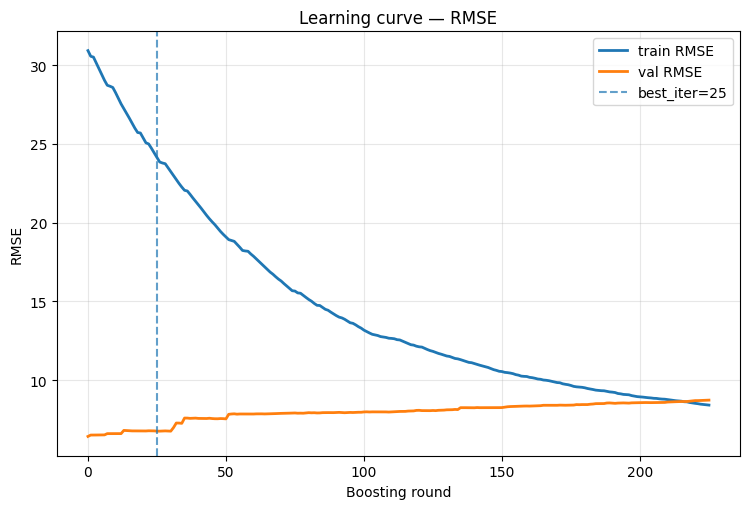

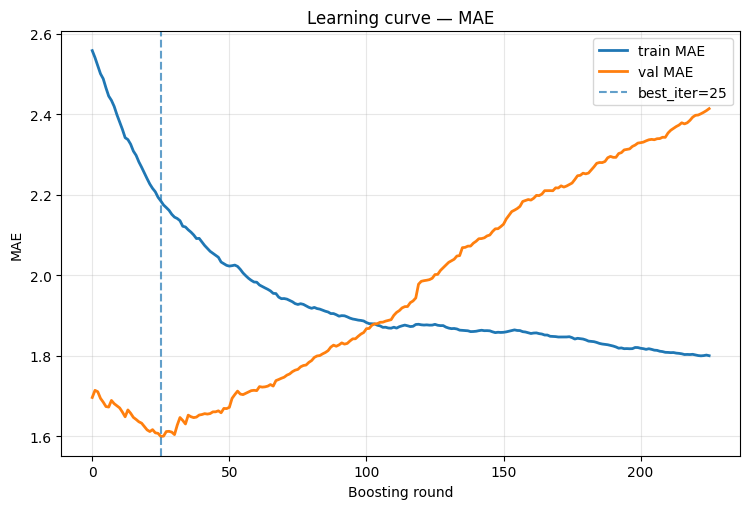

In [5]:
plt.figure(figsize=(7.6,5.2))
plt.plot(evals_result["train"]["rmse"], label="train RMSE", lw=2)
plt.plot(evals_result["val"]["rmse"],   label="val RMSE",   lw=2)
if best_iter is not None: plt.axvline(best_iter, ls="--", alpha=0.7, label=f"best_iter={best_iter}")
plt.xlabel("Boosting round"); plt.ylabel("RMSE"); plt.title("Learning curve — RMSE")
plt.grid(True, alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(7.6,5.2))
plt.plot(evals_result["train"]["mae"], label="train MAE", lw=2)
plt.plot(evals_result["val"]["mae"],   label="val MAE",   lw=2)
if best_iter is not None: plt.axvline(best_iter, ls="--", alpha=0.7, label=f"best_iter={best_iter}")
plt.xlabel("Boosting round"); plt.ylabel("MAE"); plt.title("Learning curve — MAE")
plt.grid(True, alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()


In [6]:
# --- Predict (ensure y_pred exists) ---
best_iter = getattr(booster, "best_iteration", None)
if best_iter is None:
    # fallback to last logged round if early stopping didn't set best_iteration
    best_iter = len(evals_result["val"]["rmse"]) - 1

# Use iteration_range (newer XGBoost). If your version lacks it, replace this with ntree_limit.
y_pred = booster.predict(dtest, iteration_range=(0, best_iter + 1))


# ensure 1D arrays
y_true = np.asarray(y_test, dtype=float).ravel()
y_pred = np.asarray(y_pred, dtype=float).ravel()

mse  = mean_squared_error(y_true, y_pred)   # MSE
rmse = np.sqrt(mse)                         # RMSE
mae  = mean_absolute_error(y_true, y_pred)
r2   = r2_score(y_true, y_pred)

# robust stats (handles different SciPy return types)
pear = pearsonr(y_true, y_pred)[0]
try:
    spear = spearmanr(y_true, y_pred).correlation
except Exception:
    spear = spearmanr(y_true, y_pred)[0]

print(f"Test RMSE: {rmse:.6g}")
print(f"Test  MAE: {mae:.6g}")
print(f"Test   R²: {r2:.4f}")
print(f"Pearson r:  {pear:.4f}")
print(f"Spearman ρ: {spear:.4f}")


Test RMSE: 33.2838
Test  MAE: 3.58691
Test   R²: -0.0143
Pearson r:  -0.0015
Spearman ρ: 0.1789


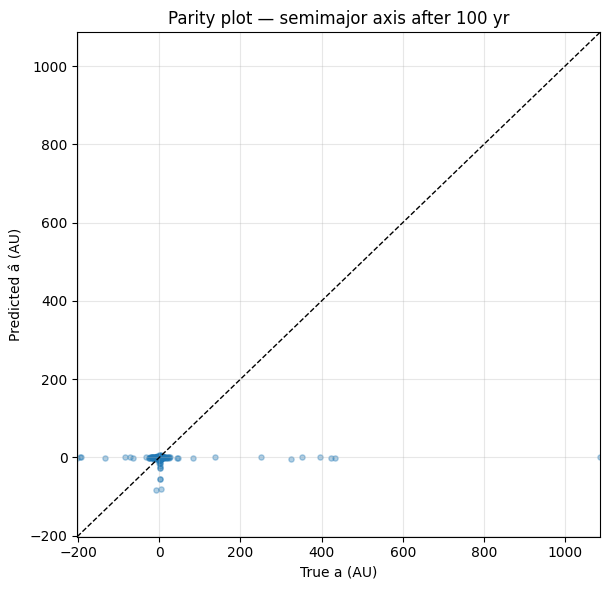

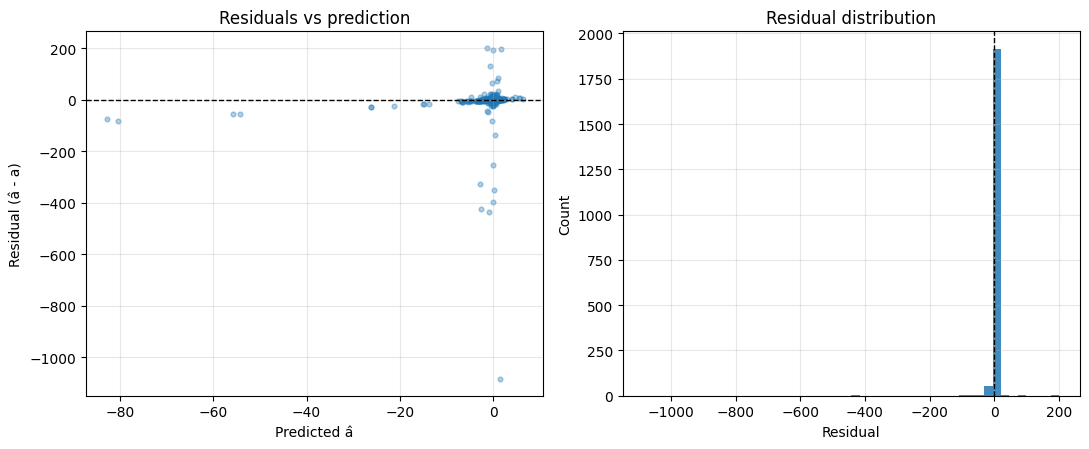

In [7]:
# Parity (y_true vs y_pred)
plt.figure(figsize=(6.2,6.0))
plt.scatter(y_test, y_pred, s=14, alpha=0.35)
lims = [np.min([y_test.min(), y_pred.min()]), np.max([y_test.max(), y_pred.max()])]
plt.plot(lims, lims, 'k--', lw=1)
plt.xlim(lims); plt.ylim(lims)
plt.xlabel("True a (AU)"); plt.ylabel("Predicted â (AU)")
plt.title("Parity plot — semimajor axis after 100 yr")
plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()

# Residuals
res = y_pred - y_test
fig, ax = plt.subplots(1,2, figsize=(11,4.6))
ax[0].scatter(y_pred, res, s=12, alpha=0.35)
ax[0].axhline(0, color="k", lw=1, ls="--")
ax[0].set_xlabel("Predicted â"); ax[0].set_ylabel("Residual (â - a)")
ax[0].set_title("Residuals vs prediction"); ax[0].grid(True, alpha=0.3)

ax[1].hist(res, bins=50, alpha=0.85)
ax[1].axvline(0, color="k", lw=1, ls="--")
ax[1].set_xlabel("Residual"); ax[1].set_ylabel("Count")
ax[1].set_title("Residual distribution")
ax[1].grid(True, alpha=0.3)
plt.tight_layout(); plt.show()


In [8]:
true_unbound = (y_test < 0)
pred_unbound = (y_pred < 0)
sign_acc = (true_unbound == pred_unbound).mean()
print(f"Sign (bound vs unbound) accuracy: {sign_acc:.3f}")


Sign (bound vs unbound) accuracy: 0.834
